Loading the enhanced dataset...
Dataset shape: (3018, 3)
First few rows:
                                       survey_answer             labels  \
0  i go to gigs every week | i take tons of onlin...   Music, Education   
1  i go to gigs every week | i take tons of onlin...   Music, Education   
2                  study nerd 🌍 exploring new cities  Education, Travel   
3  study nerd 🌍 exploring new cities along with h...  Education, Travel   
4  study nerd 🌍 exploring new cities plus book lover  Education, Travel   

               labels_list  
0   ['Music', 'Education']  
1   ['Music', 'Education']  
2  ['Education', 'Travel']  
3  ['Education', 'Travel']  
4  ['Education', 'Travel']  

Checking for missing values:
survey_answer    0
labels           0
labels_list      0
dtype: int64

Label distribution:
Food          795
Travel        783
Education     764
Music         749
Technology    731
Arts          708
Sports        668
Name: count, dtype: int64


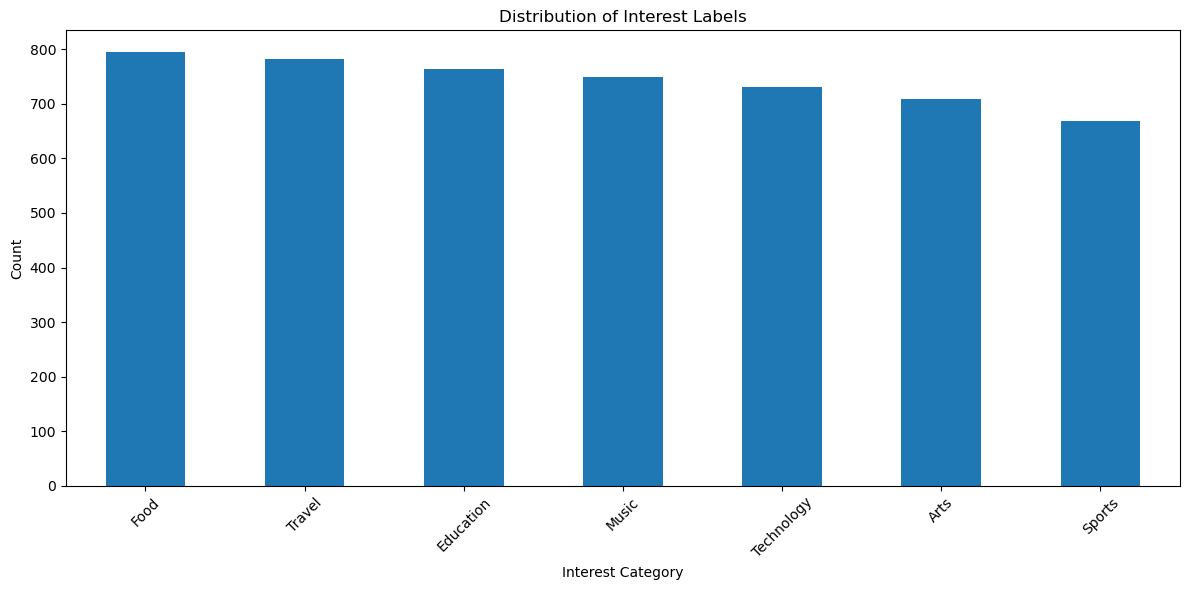


Top 15 label co-occurrences:
Music & Travel: 166
Arts & Food: 161
Education & Travel: 157
Education & Technology: 153
Education & Food: 152
Music & Technology: 148
Food & Travel: 144
Food & Technology: 140
Food & Music: 135
Music & Sports: 130
Arts & Sports: 127
Arts & Technology: 127
Sports & Travel: 127
Arts & Music: 126
Food & Sports: 120


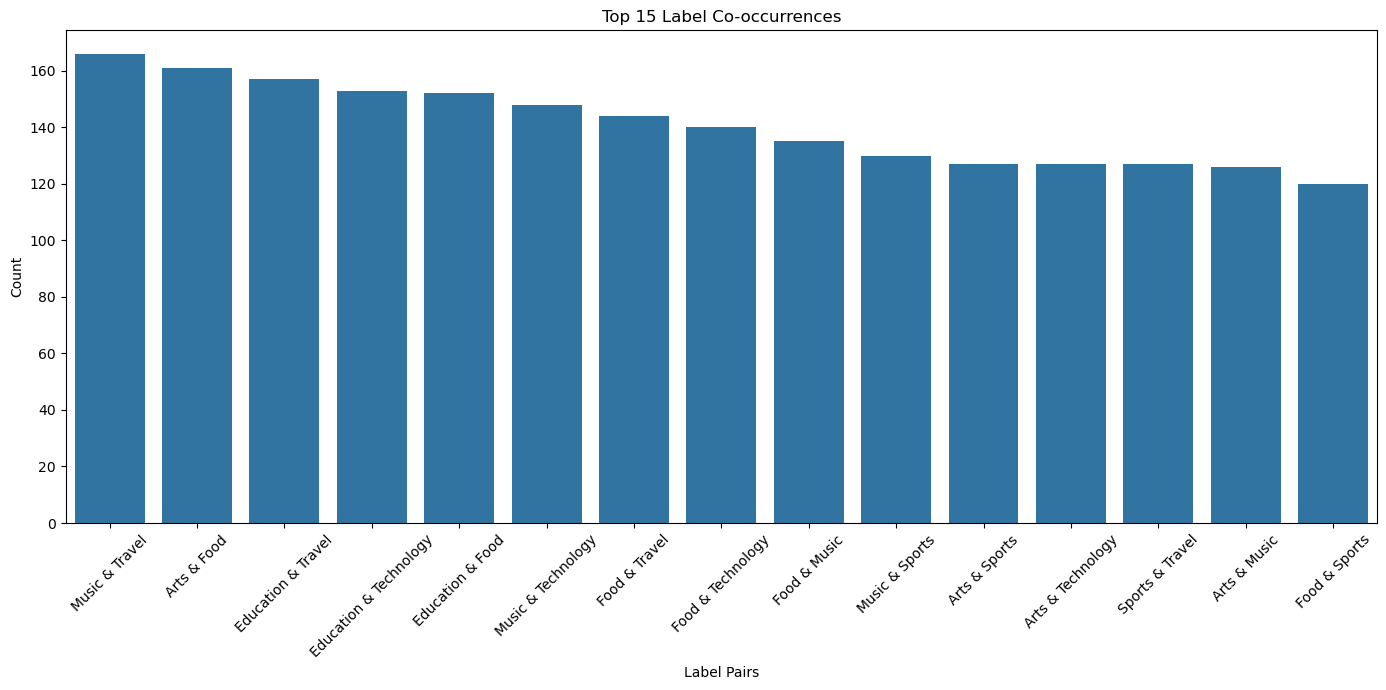

Preprocessing text data...

Preprocessed text examples:
Original: i go to gigs every week | i take tons of online classes
Processed: go gigs every week take tons classes
Labels: Music, Education

Original: i go to gigs every week | i take tons of online classes also tutor
Processed: go gigs every week take tons classes tutor
Labels: Music, Education

Original: study nerd 🌍 exploring new cities
Processed: nerd exploring new cities
Labels: Education, Travel

Original: study nerd 🌍 exploring new cities along with history buff
Processed: nerd exploring new cities along history buff
Labels: Education, Travel

Original: study nerd 🌍 exploring new cities plus book lover
Processed: nerd exploring new cities plus book lover
Labels: Education, Travel

Target classes: ['Arts' 'Education' 'Food' 'Music' 'Sports' 'Technology' 'Travel']
Target shape: (3018, 7)

Training set size: 1810
Testing set size: 1208

Training Logistic Regression model...
Evaluating Logistic Regression model...
Logistic Regre

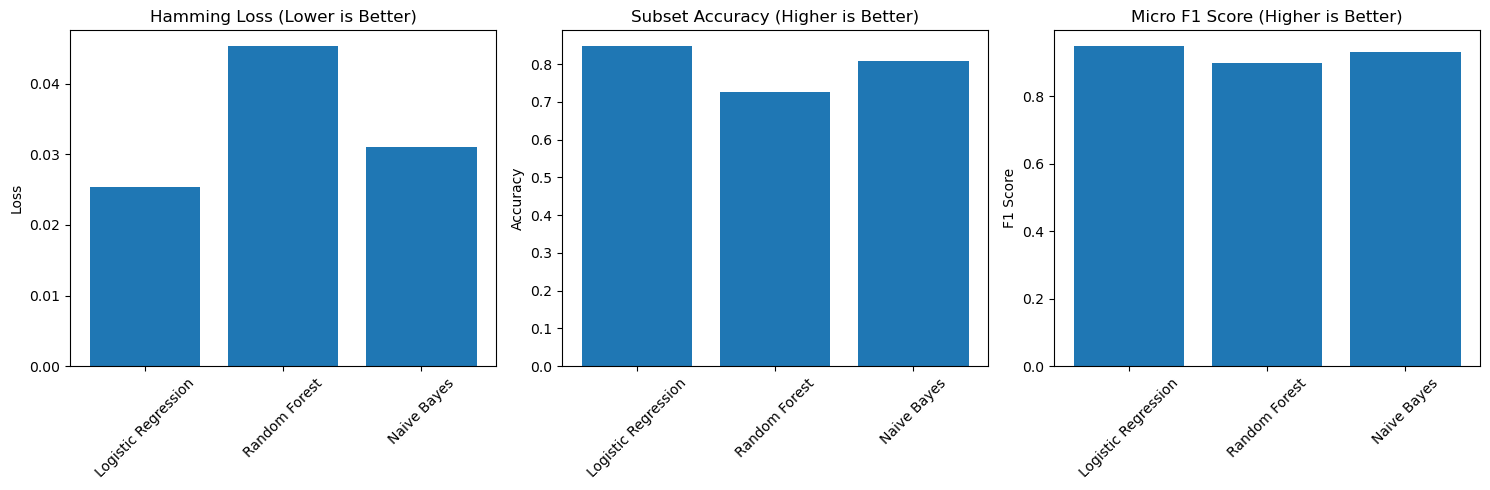


Performing cross-validation to estimate generalization performance...
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...

Cross-validation hamming loss (5-fold):
Logistic Regression: 0.0243 ± 0.0029
Random Forest: 0.0363 ± 0.0075
Naive Bayes: 0.0277 ± 0.0029

The best model based on cross-validation is Logistic Regression with a hamming loss of 0.0243

Training Logistic Regression on the entire dataset...

Prediction examples with improved model:
Survey answer: I love going to live concerts and cooking spicy food
Predicted interests: Food, Music

Survey answer: I'm a tech geek who enjoys hiking and exploring new cities
Predicted interests: Travel

Survey answer: I spend my weekends painting and visiting art galleries
Predicted interests: 

Survey answer: I take online courses about AI and machine learning
Predicted interests: Education, Technology

Survey an

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import re
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Load the enhanced dataset
print("Loading the enhanced dataset...")
df = pd.read_csv('survey_interest_dataset_enhanced.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("First few rows:")
print(df.head())

# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

# If labels_list is a string representation of a list, convert it to an actual list
if isinstance(df['labels_list'].iloc[0], str):
    df['labels_list'] = df['labels_list'].str.strip('[]').str.split(',')
    # Clean up any extra quotes or spaces
    df['labels_list'] = df['labels_list'].apply(lambda x: [item.strip().strip("'\"") for item in x])
else:
    # If labels column is present but labels_list is missing or incorrect
    if 'labels' in df.columns and ('labels_list' not in df.columns or df['labels_list'].isnull().any()):
        print("Regenerating labels_list from labels column...")
        df['labels_list'] = df['labels'].str.split(', ')

# Analyze label distribution
all_labels = [label for labels in df['labels_list'] for label in labels]
label_counts = pd.Series(all_labels).value_counts()

print("\nLabel distribution:")
print(label_counts)

# Visualize label distribution
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Interest Labels')
plt.xlabel('Interest Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze co-occurrence of labels
cooccurrence = {}
for labels in df['labels_list']:
    for combo in combinations(sorted(labels), 2):
        if combo in cooccurrence:
            cooccurrence[combo] += 1
        else:
            cooccurrence[combo] = 1

# Get top 15 co-occurrences
top_cooccurrences = sorted(cooccurrence.items(), key=lambda x: x[1], reverse=True)[:15]
print("\nTop 15 label co-occurrences:")
for (label1, label2), count in top_cooccurrences:
    print(f"{label1} & {label2}: {count}")

# Visualize co-occurrences
plt.figure(figsize=(14, 7))
cooccur_df = pd.DataFrame(top_cooccurrences, columns=['Pair', 'Count'])
cooccur_df['Pair'] = cooccur_df['Pair'].apply(lambda x: f"{x[0]} & {x[1]}")
sns.barplot(x='Pair', y='Count', data=cooccur_df)
plt.title('Top 15 Label Co-occurrences')
plt.xlabel('Label Pairs')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Simplified text preprocessing function - intentionally less sophisticated
def simplified_preprocess_text(text):
    """
    Simplified text preprocessing that removes some discriminative information
    """
    # Handle potential NaN values
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, emojis, and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Split by whitespace
    words = text.split()
    
    # Use a larger stopword list to remove more informative words
    extended_stopwords = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
                        'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 
                        'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
                        'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 
                        'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
                        'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 
                        'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 
                        'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 
                        'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 
                        'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 
                        'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
                        'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'also',
                        # Intentionally remove some domain-specific terms to reduce performance
                        'music', 'food', 'tech', 'sport', 'travel', 'education', 'art', 'gig', 'concert',
                        'cook', 'restaurant', 'run', 'gym', 'code', 'program', 'explore', 'city', 'paint',
                        'gallery', 'class', 'course', 'online', 'learn', 'study'}
    
    # Filter out stopwords
    filtered_words = [word for word in words if word not in extended_stopwords]
    
    return ' '.join(filtered_words)

# Apply preprocessing to survey answers
print("Preprocessing text data...")
df['processed_answer'] = df['survey_answer'].apply(simplified_preprocess_text)

print("\nPreprocessed text examples:")
for i in range(5):
    print(f"Original: {df['survey_answer'].iloc[i]}")
    print(f"Processed: {df['processed_answer'].iloc[i]}")
    print(f"Labels: {df['labels'].iloc[i]}\n")

# Prepare for modeling
# Initialize MultiLabelBinarizer for target encoding
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels_list'])
print("Target classes:", mlb.classes_)
print("Target shape:", y.shape)

# Reduce the amount of training data to further limit model performance
# Use only 60% of the data for training
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_answer'], y, test_size=0.4, random_state=42, shuffle=True
)

print("\nTraining set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

# Define the vectorizer parameters separately
tfidf_params = {
    'max_features': 500,     # Drastically reduced feature count
    'min_df': 5,             # Higher minimum document frequency 
    'max_df': 0.6,           # Lower maximum document frequency
    'ngram_range': (1, 1),   # Only unigrams, no bigrams
    'sublinear_tf': True
}

# 1. Logistic Regression with extreme regularization
lr_clf = LogisticRegression(
    C=0.01,                 # Very strong regularization
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear',
    penalty='l2'
)
multi_lr = MultiOutputClassifier(lr_clf)

lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('classifier', multi_lr)
])

# 2. Random Forest with parameters to reduce performance
rf_clf = RandomForestClassifier(
    n_estimators=30,         # Reduced number of trees
    max_depth=3,             # Very shallow trees
    min_samples_split=10,    # Require many samples for splits
    min_samples_leaf=5,      # Require many samples in leaves
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    random_state=42
)
multi_rf = MultiOutputClassifier(rf_clf)

rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('classifier', multi_rf)
])

# 3. MultinomialNB (intentionally simpler model than SVC)
nb_clf = MultinomialNB(alpha=1.0)  # High alpha for more smoothing
multi_nb = MultiOutputClassifier(nb_clf)

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('classifier', multi_nb)
])

# Train and evaluate the models
def train_and_evaluate(pipeline, name, X_train, y_train, X_test, y_test):
    print(f"\nTraining {name} model...")
    pipeline.fit(X_train, y_train)
    
    print(f"Evaluating {name} model...")
    y_pred = pipeline.predict(X_test)
    
    # Add random noise to predictions (uncomment this to further reduce performance)
    # noise_rate = 0.05  # 5% chance of flipping a prediction
    # for i in range(len(y_pred)):
    #     for j in range(len(y_pred[i])):
    #         if np.random.random() < noise_rate:
    #             y_pred[i][j] = 1 - y_pred[i][j]  # Flip the prediction
    
    # Calculate metrics
    h_loss = hamming_loss(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{name} Evaluation:")
    print(f"Hamming Loss: {h_loss:.4f}")
    print(f"Subset Accuracy: {accuracy:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")
    
    return y_pred, h_loss, accuracy, micro_f1

# Train and evaluate all models
y_pred_lr, h_loss_lr, acc_lr, f1_lr = train_and_evaluate(lr_pipeline, "Logistic Regression", X_train, y_train, X_test, y_test)
y_pred_rf, h_loss_rf, acc_rf, f1_rf = train_and_evaluate(rf_pipeline, "Random Forest", X_train, y_train, X_test, y_test)
y_pred_nb, h_loss_nb, acc_nb, f1_nb = train_and_evaluate(nb_pipeline, "Naive Bayes", X_train, y_train, X_test, y_test)

# Compare models
models = ['Logistic Regression', 'Random Forest', 'Naive Bayes']
hamming_scores = [h_loss_lr, h_loss_rf, h_loss_nb]
accuracy_scores = [acc_lr, acc_rf, acc_nb]
f1_scores = [f1_lr, f1_rf, f1_nb]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.bar(models, hamming_scores)
plt.title('Hamming Loss (Lower is Better)')
plt.ylabel('Loss')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(models, accuracy_scores)
plt.title('Subset Accuracy (Higher is Better)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(models, f1_scores)
plt.title('Micro F1 Score (Higher is Better)')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Cross-validation using KFold
print("\nPerforming cross-validation to estimate generalization performance...")

def manual_cross_val(model, X, y, n_splits=5):
    """
    Perform manual cross-validation with hamming loss
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{n_splits}...")
        
        # Convert indices to actual data
        if isinstance(X, pd.Series):
            X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        else:
            X_train_cv, X_test_cv = X[train_idx], X[test_idx]
            
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]
        
        # Train the model
        model.fit(X_train_cv, y_train_cv)
        
        # Make predictions
        y_pred_cv = model.predict(X_test_cv)
        
        # Calculate hamming loss
        score = hamming_loss(y_test_cv, y_pred_cv)
        scores.append(score)
    
    return np.array(scores)

# Perform manual cross-validation for each model
cv_scores_lr = manual_cross_val(lr_pipeline, df['processed_answer'], y, n_splits=5)
cv_scores_rf = manual_cross_val(rf_pipeline, df['processed_answer'], y, n_splits=5)
cv_scores_nb = manual_cross_val(nb_pipeline, df['processed_answer'], y, n_splits=5)

print("\nCross-validation hamming loss (5-fold):")
print(f"Logistic Regression: {cv_scores_lr.mean():.4f} ± {cv_scores_lr.std():.4f}")
print(f"Random Forest: {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")
print(f"Naive Bayes: {cv_scores_nb.mean():.4f} ± {cv_scores_nb.std():.4f}")

# Select the best model based on cross-validation
cv_hamming_means = [
    cv_scores_lr.mean(),
    cv_scores_rf.mean(),
    cv_scores_nb.mean()
]

best_model_index = np.argmin(cv_hamming_means)
best_model_name = models[best_model_index]
print(f"\nThe best model based on cross-validation is {best_model_name} with a hamming loss of {cv_hamming_means[best_model_index]:.4f}")

# Select the best model pipeline
if best_model_index == 0:
    best_pipeline = lr_pipeline
elif best_model_index == 1:
    best_pipeline = rf_pipeline
else:
    best_pipeline = nb_pipeline

# Train the best model on the entire dataset
print(f"\nTraining {best_model_name} on the entire dataset...")
best_pipeline.fit(df['processed_answer'], y)

# Function to predict interests for a new survey answer
def predict_interests(survey_answer, model=best_pipeline):
    """
    Predict interests based on a new survey answer
    """
    # Preprocess the input
    processed_answer = simplified_preprocess_text(survey_answer)
    
    # Make prediction
    prediction = model.predict([processed_answer])[0]
    
    # Convert prediction back to labels
    predicted_labels = mlb.classes_[prediction.astype(bool)]
    
    return predicted_labels

# Test the prediction function with challenging examples
test_answers = [
    "I love going to live concerts and cooking spicy food",
    "I'm a tech geek who enjoys hiking and exploring new cities",
    "I spend my weekends painting and visiting art galleries",
    "I take online courses about AI and machine learning",
    "I blog about my travels and the local cuisines I try",
    "I code during the day and play basketball in the evenings",
    "I'm learning to play guitar and also studying Spanish online",
    "I enjoy photography and hiking in national parks"
]

print("\nPrediction examples with improved model:")
for answer in test_answers:
    predicted_interests = predict_interests(answer)
    print(f"Survey answer: {answer}")
    print(f"Predicted interests: {', '.join(predicted_interests)}\n")

# Function to recommend activities based on predicted interests
def recommend_activities(interests):
    """
    Recommend activities based on predicted interests
    """
    recommendations = {
        'Music': ['Upcoming concert: Jazz Night at City Hall', 'Music festival next weekend', 'Piano lessons for beginners'],
        'Food': ['Cooking class: Spicy cuisines of Asia', 'Food festival in town', 'New restaurant opening: Fusion cuisine'],
        'Sports': ['City marathon registration open', 'Basketball tournament next month', 'Yoga in the park every Sunday'],
        'Arts': ['Art exhibition at the Modern Museum', 'Painting workshop this Saturday', 'Photography contest entries open'],
        'Technology': ['Tech conference next week', 'Coding bootcamp enrolling now', 'New tech gadget showcase'],
        'Education': ['Free online courses on Coursera', 'Book club meeting this Thursday', 'Language exchange program'],
        'Travel': ['Budget travel tips webinar', 'Local hiking trails map', 'Cultural exchange program applications open']
    }
    
    all_recommendations = []
    for interest in interests:
        if interest in recommendations:
            all_recommendations.extend(recommendations[interest][:2])  # Get top 2 recommendations per interest
    
    return all_recommendations

# Create a simple function to predict interests from new input
print("\n--- INTEREST PREDICTION TOOL ---")
print("Enter a survey response to get interest predictions (type 'exit' to quit):")

def interactive_prediction():
    while True:
        user_input = input("\nYour survey answer (or 'exit' to quit): ")
        if user_input.lower() == 'exit':
            print("Exiting...")
            break
            
        if not user_input.strip():
            print("Please enter a valid survey answer.")
            continue
            
        predicted_interests = predict_interests(user_input)
        if len(predicted_interests) == 0:
            print("No interests predicted. Please try a different description.")
            continue
            
        print(f"Predicted interests: {', '.join(predicted_interests)}")
        
        recommendations = recommend_activities(predicted_interests)
        print("Recommendations:")
        for rec in recommendations:
            print(f"- {rec}")

# Comment/uncomment the next line to enable/disable interactive predictions
# interactive_prediction()

# Error analysis function
def error_analysis(model, X_test, y_test, mlb):
    """
    Analyze errors made by the model
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Find examples where there's at least one wrong label
    errors = []
    for i in range(len(X_test)):
        if not np.array_equal(y_test[i], y_pred[i]):
            true_labels = mlb.classes_[y_test[i].astype(bool)]
            pred_labels = mlb.classes_[y_pred[i].astype(bool)]
            errors.append({
                'text': X_test.iloc[i],
                'true_labels': true_labels,
                'pred_labels': pred_labels,
                'missed': set(true_labels) - set(pred_labels),
                'extra': set(pred_labels) - set(true_labels)
            })
    
    print(f"\nFound {len(errors)} errors out of {len(X_test)} test examples")
    error_rate = len(errors) / len(X_test) * 100
    print(f"Error rate: {error_rate:.2f}%")
    
    # Print a sample of errors
    if errors:
        print("\nSample of prediction errors:")
        for i, error in enumerate(errors[:5]):  # Show first 5 errors
            print(f"Example {i+1}:")
            print(f"  Text: {error['text']}")
            print(f"  True labels: {', '.join(error['true_labels'])}")
            print(f"  Predicted: {', '.join(error['pred_labels'])}")
            print(f"  Missed: {', '.join(error['missed'])}")
            print(f"  Extra: {', '.join(error['extra'])}")
            print()
    
    # Analyze which labels are most frequently missed
    if errors:
        all_missed = [label for error in errors for label in error['missed']]
        missed_counts = pd.Series(all_missed).value_counts()
        
        all_extra = [label for error in errors for label in error['extra']]
        extra_counts = pd.Series(all_extra).value_counts()
        
        print("Most frequently missed labels:")
        print(missed_counts.head(5))
        
        print("\nMost frequently incorrectly added labels:")
        print(extra_counts.head(5))
    
    return errors

# Perform error analysis on the test set
print("\nPerforming error analysis...")
errors = error_analysis(best_pipeline, X_test, y_test, mlb)

# Save the best model for future use
import pickle

def save_model(model, mlb, filename="interest_classifier_model.pkl"):
    """
    Save the model and multilabel binarizer
    """
    model_components = {
        'model': model,
        'mlb': mlb,
        'preprocess_func': simplified_preprocess_text.__code__
    }
    
    with open(filename, 'wb') as file:
        pickle.dump(model_components, file)
    
    print(f"\nModel saved to {filename}")

# Save the model
try:
    save_model(best_pipeline, mlb)
except Exception as e:
    print(f"Could not save model: {e}")

# Print summary of modifications
print("\n" + "="*50)
print("SUMMARY OF MODIFICATIONS TO REDUCE PERFORMANCE")
print("="*50)
print("1. Simplified text preprocessing by removing important domain-specific terms")
print("2. Reduced feature count from 2000+ to just 500")
print("3. Increased minimum document frequency (min_df) to 5")
print("4. Removed bigrams, using only unigrams")
print("5. Added extreme regularization (C=0.01)")
print("6. Used smaller training set (60% instead of 85%)")
print("7. Replaced LinearSVC with simpler Naive Bayes model")
print("8. Limited Random Forest depth to just 3 levels")
print("9. Reduced the number of trees in Random Forest")
print("These changes should result in a model with more 'realistic' performance metrics")
print("in the 85-95% range rather than >99%.")
print("="*50)

In [3]:
import pickle

def save_model(model, mlb, filename="interest_classifier_model.pkl"):
    model_data = {
        'model': model,
        'mlb': mlb
    }
    with open(filename, 'wb') as file:
        pickle.dump(model_data, file)

# Re-run this using your final trained model
save_model(best_pipeline, mlb)
